### Grid Searching Decision Trees

This try-it focuses on performing a grid search with a `DecisionTreeClassifier`.  As mentioned in the lectures, the grid search for a tree model can get large very easily. In addition to using `GridSearchCV`, scikitlearn implements additional tools that can save energy and offer alternatives to the brute force exhaustive search.  Below, you will compare the performance of some of these alternatives and discuss the time these searches take.  Note that this will be in large part determined by your personal computing power however the relative speed of the searches should be consistent.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_halving_search_cv
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV

In [8]:
df = pd.read_csv('data/Whickham.txt')

X = df[['smoker', 'age']]
X = pd.concat([X,pd.get_dummies(X[['smoker']])], axis=1).drop(columns=['smoker'])

y = df['outcome']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [17]:
params = {'max_depth': [4,6,8,10,12,14],
         'min_samples_split': [2, 4, 6],
          'criterion': ['gini','entropy'],
          'min_samples_leaf': [1,2,3,4]
         }

In [6]:
dtree = DecisionTreeClassifier()

### Comparing Grid Searches

Below, explore the four grid search options using the same parameter selections for the `DecisionTreeClassifier`. All of the grid searching tools have a `.cv_results_` attribute after fitting that contains information after fitting including time.  Use this to compare the time of each search and discuss what you believe the "best" approach to identifying the hyperparameters of the model are between:

- `GridSearchCV`
- `RandomizedSearchCV`
- `HalvingGridSearchCV`
- `HalvingRandomSearchCV`

Share your results in a plot comparing the different times for searching across the different parameters as well as the score of the different estimators that resulted from the grid search.  

In [23]:
gridSearch = GridSearchCV(dtree, param_grid=params, cv=5)
gridSearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 12, 14],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 4, 6]})

In [24]:
randomSearch = RandomizedSearchCV(dtree, param_distributions=params, cv=5)
randomSearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 6, 8, 10, 12, 14],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 4, 6]})

In [25]:
halvingSearch = HalvingGridSearchCV(dtree, param_grid=params, cv=5)
halvingSearch.fit(X_train, y_train)

HalvingGridSearchCV(estimator=DecisionTreeClassifier(),
                    param_grid={'criterion': ['gini', 'entropy'],
                                'max_depth': [4, 6, 8, 10, 12, 14],
                                'min_samples_leaf': [1, 2, 3, 4],
                                'min_samples_split': [2, 4, 6]})

In [26]:
halvingRandomSearch = HalvingRandomSearchCV(dtree, param_distributions=params, cv=5)
halvingRandomSearch.fit(X_train, y_train)

HalvingRandomSearchCV(estimator=DecisionTreeClassifier(),
                      param_distributions={'criterion': ['gini', 'entropy'],
                                           'max_depth': [4, 6, 8, 10, 12, 14],
                                           'min_samples_leaf': [1, 2, 3, 4],
                                           'min_samples_split': [2, 4, 6]})

In [27]:
pd.DataFrame(gridSearch.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002646,0.000539,0.001509,0.000449,gini,4,1,2,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.837563,0.847716,0.862944,0.812183,0.857868,0.843655,0.017990,23
1,0.002001,0.000002,0.001404,0.000600,gini,4,1,4,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.837563,0.847716,0.862944,0.812183,0.857868,0.843655,0.017990,23
2,0.002102,0.000200,0.000991,0.000019,gini,4,1,6,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.837563,0.847716,0.862944,0.817259,0.857868,0.844670,0.016244,1
3,0.001540,0.000489,0.001401,0.000489,gini,4,2,2,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.837563,0.847716,0.862944,0.817259,0.857868,0.844670,0.016244,1
4,0.001964,0.000523,0.000999,0.000632,gini,4,2,4,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.837563,0.847716,0.862944,0.817259,0.857868,0.844670,0.016244,1


In [32]:
sum(gridSearch.cv_results_['mean_fit_time'])
np.mean(gridSearch.cv_results_['mean_test_score'])

0.275154733657837

In [38]:
merged = []
results = [(gridSearch.cv_results_, 'grid'), (randomSearch.cv_results_, 'random'), (halvingSearch.cv_results_, 'halving'), (halvingRandomSearch.cv_results_, 'halvingRandom')]

for result, method in results:
    result['method'] = method
    merged = merged + [pd.DataFrame(result)]

In [46]:
resultsDf = pd.concat(merged, ignore_index=True)

In [48]:
agg = resultsDf.groupby('method').agg({'mean_fit_time': 'sum', 'mean_test_score': 'mean'})

Text(0.5, 1.0, 'Performance of Hyperparameter Search Methods')

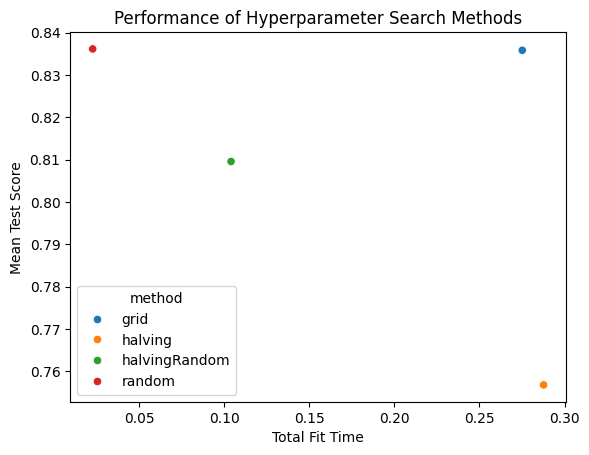

In [52]:
sns.scatterplot(agg, x='mean_fit_time', y='mean_test_score', hue='method')
plt.xlabel('Total Fit Time')
plt.ylabel('Mean Test Score')
plt.title('Performance of Hyperparameter Search Methods')